In [1]:
import time
#import space
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import numpy as np
import pandas as pd
import os
%matplotlib notebook
%matplotlib notebook
import matplotlib
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,mark_inset
from scipy.constants import c, h, physical_constants
from uncertainties import ufloat
from uncertainties import umath
from tqdm.notebook import tqdm
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
#sys.path.insert(1, '/Users/aidanmcconnell/Documents/PhD/FTIR_functions')

import ftir_interferrogram_functions as ftFuncs

import scipy
from scipy import signal
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from scipy.stats.distributions import t
import scipy.constants as const

from lmfit.models import ConstantModel, LorentzianModel, LinearModel
from lmfit.model import save_modelresult, load_modelresult
from lmfit.printfuncs import report_ci

############################# initialises some parameters for code #############################

# location of measurement files
parentDir = "E:/Theo_Silicon/"                                              ### adjust this for new experiment
measurementName = "2023-05-24_SUN_18K"                                      ### adjust this for new experiment
sampleName = "1e13 cm-3 bulk doped Phosphorus (Sun)"                        ### adjust this for new experiment
path = os.path.join(parentDir, measurementName, "ASCII Files/") 

# location of reference scans
refScan1 = "2023-05-24_SUN_4K"                                          ### adjust this for new experiment
refPath1 = os.path.join(parentDir, refScan1, "ASCII Files/")

# creates new folder to store processed data
folderpath = os.path.join(parentDir, measurementName, "Processed data/")

if not os.path.isdir(folderpath):
    os.mkdir(folderpath)
    print('created new folder at ' + folderpath)
    
# creates new folder to store plots and results
resultspath = os.path.join(parentDir, measurementName, "results/")

if not os.path.isdir(resultspath):
    os.mkdir(resultspath)
    print('created new folder at ' + resultspath)
    
# names and location of processed reference data files    
nameReferenceData1Averaged = refScan1 + "_averaged.txt" 
pathReferenceData1Averaged = os.path.join(folderpath, nameReferenceData1Averaged)

# names and location of averaged data files
nameDataAveraged = measurementName + '_averaged.txt' 
pathDataAveraged = os.path.join(folderpath, nameDataAveraged)

# names and location of smoothed data files
nameDataSmoothed = measurementName + "_averagedAndSmoothed.txt"
pathDataSmoothed = os.path.join(folderpath, nameDataSmoothed)

# names of fourier transformed data files
nameDataRoughFt = measurementName + "_averaged_FT.txt"
pathDataRoughFt = os.path.join(folderpath, nameDataRoughFt)
nameDataSmoothFt = measurementName + "_averagedAndSmoothed_FT.txt"
pathDataSmoothFt = os.path.join(folderpath, nameDataSmoothFt)
nameRef1Ft = refScan1 + "_FT.txt"
pathRef1Ft = os.path.join(folderpath, nameRef1Ft)

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

C:\Users\theow\Anaconda3\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cell compiled at 2023-06-13 14:41:49


# This section has functions to help set up IFG


12 data sets processed


<IPython.core.display.Javascript object>


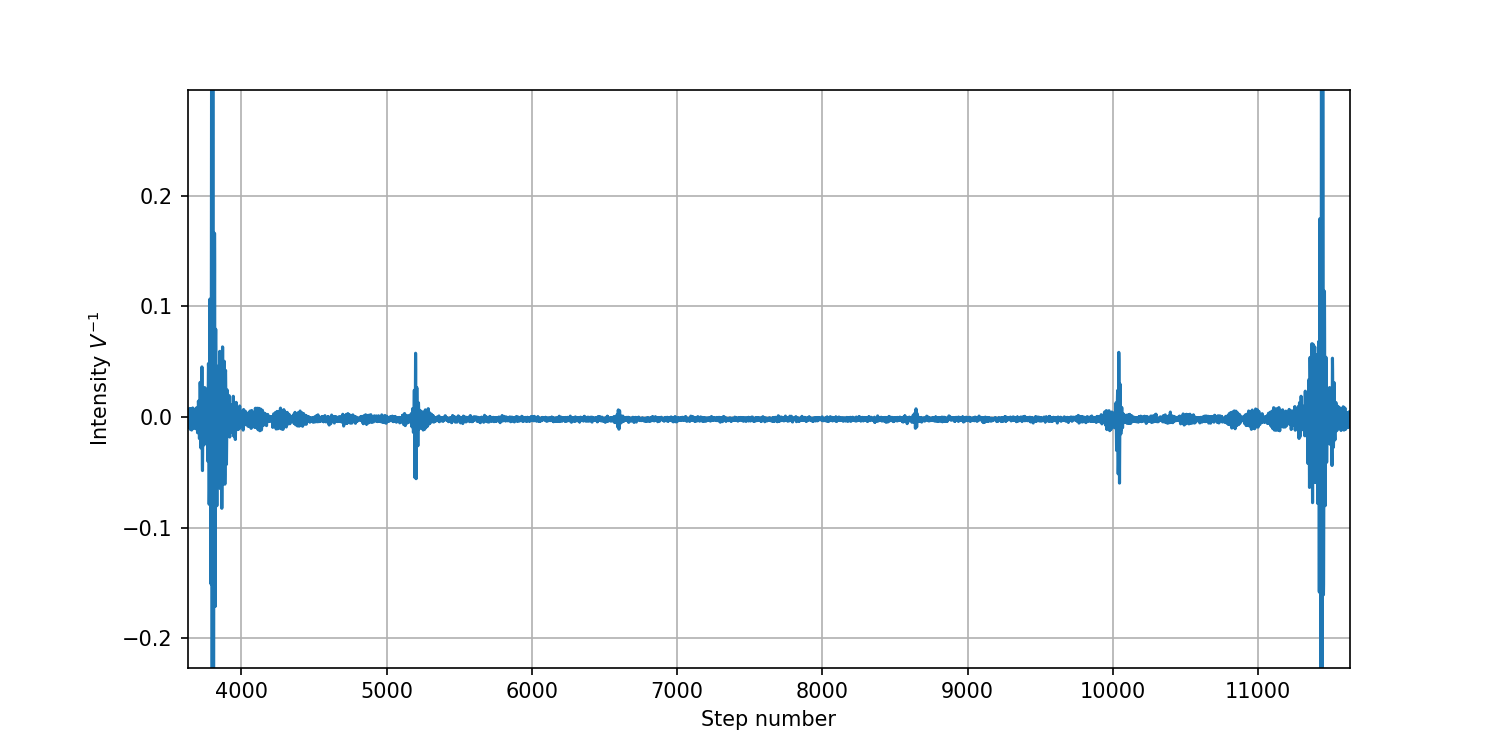

deleted old version of 2023-05-24_SUN_18K_averaged.txt
saved file 2023-05-24_SUN_18K_averaged.txt
Cell compiled at 2023-06-13 13:14:50


In [3]:
# averages data from txt files to single file
averaged_IFG = ftFuncs.average_IFGs_from_folder(path)

averaged_IFG["IFG Value"] *= 10

saveFigTo = os.path.join(resultspath, "IFG.png")
saveFigTo2 = os.path.join(resultspath, "IFG.eps")

plt.figure(figsize=(10, 5))
plt.plot(averaged_IFG["Step"], averaged_IFG["IFG Value"])
plt.xlabel("Step number")
plt.ylabel("Intensity $V^{-1}$")
plt.grid()
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()

# saves averaged data to txt file
if os.path.isfile(pathDataAveraged):
    os.remove(pathDataAveraged)
    print("deleted old version of " + nameDataAveraged)    

averaged_IFG.to_csv(pathDataAveraged, header=None, index=None, sep='\t', mode='a')
print("saved file " + nameDataAveraged)
print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Smoothens data by removing internal reflection peaks


Average noise level =  0.0210313429002193
75 % of data noise below:  0.005012520833333332
Cutoff at:  0.005012520833333332
Peak tolerance at: 0.0060150249999999985


deleted old version of 2023-05-24_SUN_18K_averagedAndSmoothed.txt
saved file 2023-05-24_SUN_18K_averagedAndSmoothed.txt


<IPython.core.display.Javascript object>


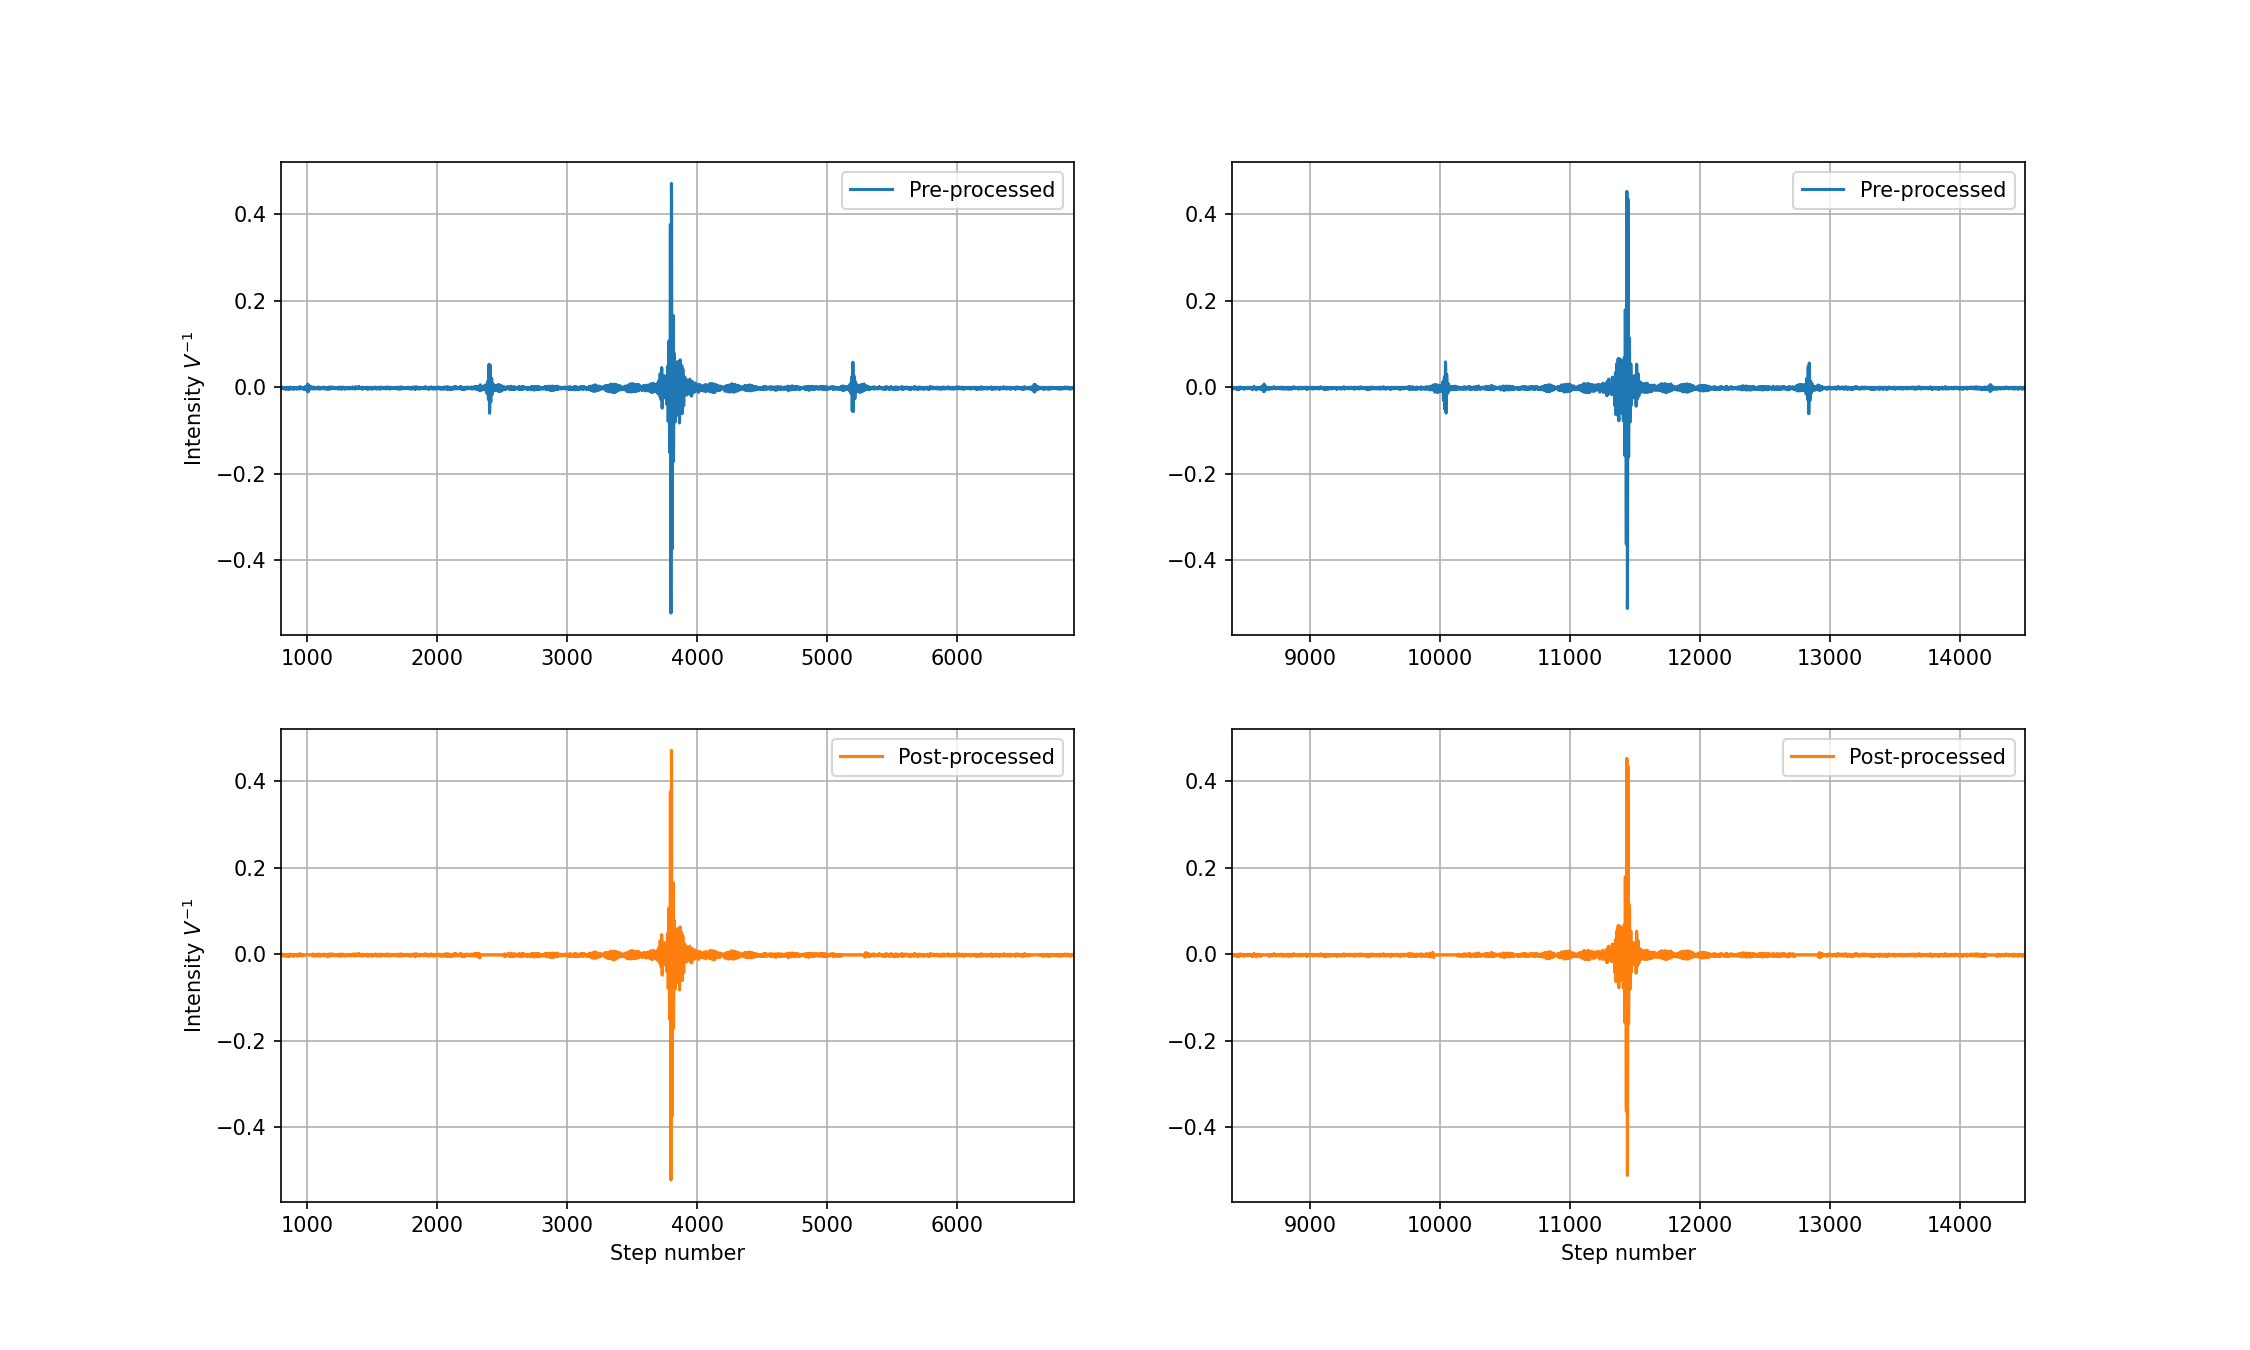

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cell compiled at 2023-06-13 14:42:03


In [2]:
if ('averaged_IFG' in locals()):
    preProcessedAverage = averaged_IFG
else:
    preProcessedAverage = pd.read_csv(pathDataAveraged, sep="\t", header=None, names=["Step", "IFG Value"])

preProcessedAverage['Step'] = preProcessedAverage['Step'].astype(int)
    
#postProcessedAverage = ftFuncs.RemovedInternalReflections(preProcessedAverage.copy(), True, 50, 75, 1, 1.2)

postProcessedAverage = preProcessedAverage.copy()
smoothingRegions = np.array([[970, 1040], [2330, 2510], [5110, 5290], [6560, 6640], [8620, 8680], [9950, 10130], [12730, 12910], [14200, 14280]])
for i in range(smoothingRegions.shape[0]):
    smoothingRegion = smoothingRegions[i]
    postProcessedAverage = ftFuncs.removed_internal_reflections(postProcessedAverage, smoothingRegion)
    
    
# saves processed data as txt
if os.path.isfile(pathDataSmoothed):
    os.remove(pathDataSmoothed)
    print("deleted old version of " + nameDataSmoothed)   

postProcessedAverage.to_csv(pathDataSmoothed, header=None, index=None, sep='\t', mode='a')
print("saved file " + nameDataSmoothed)

saveFigTo = os.path.join(resultspath, "BeforeAndAfterSmoothing.png")
saveFigTo2 = os.path.join(resultspath, "BeforeAndAfterSmoothing.eps")

plotRange1 = [800,6900] # set range which to plot here
plotRange2 = [8400, 14500]

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(222)
ax4 = fig.add_subplot(224)
ax1.plot(preProcessedAverage["IFG Value"], label = "Pre-processed", color = 'C0')
ax2.plot(postProcessedAverage["IFG Value"], label = "Post-processed", color = 'C1')
ax3.plot(preProcessedAverage["IFG Value"], label = "Pre-processed", color = 'C0')
ax4.plot(postProcessedAverage["IFG Value"], label = "Post-processed", color = 'C1')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_xlim(plotRange1)
ax2.set_xlim(plotRange1)
ax3.set_xlim(plotRange2)
ax4.set_xlim(plotRange2)
ax2.set_xlabel("Step number")
ax4.set_xlabel("Step number")
ax1.set_ylabel("Intensity $V^{-1}$")
ax2.set_ylabel("Intensity $V^{-1}$")
ax1.grid(axis='both', which='both')
ax2.grid(axis='both', which='both')
ax3.grid(axis='both', which='both')
ax4.grid(axis='both', which='both')
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Averages reference data


10 data sets processed


<IPython.core.display.Javascript object>


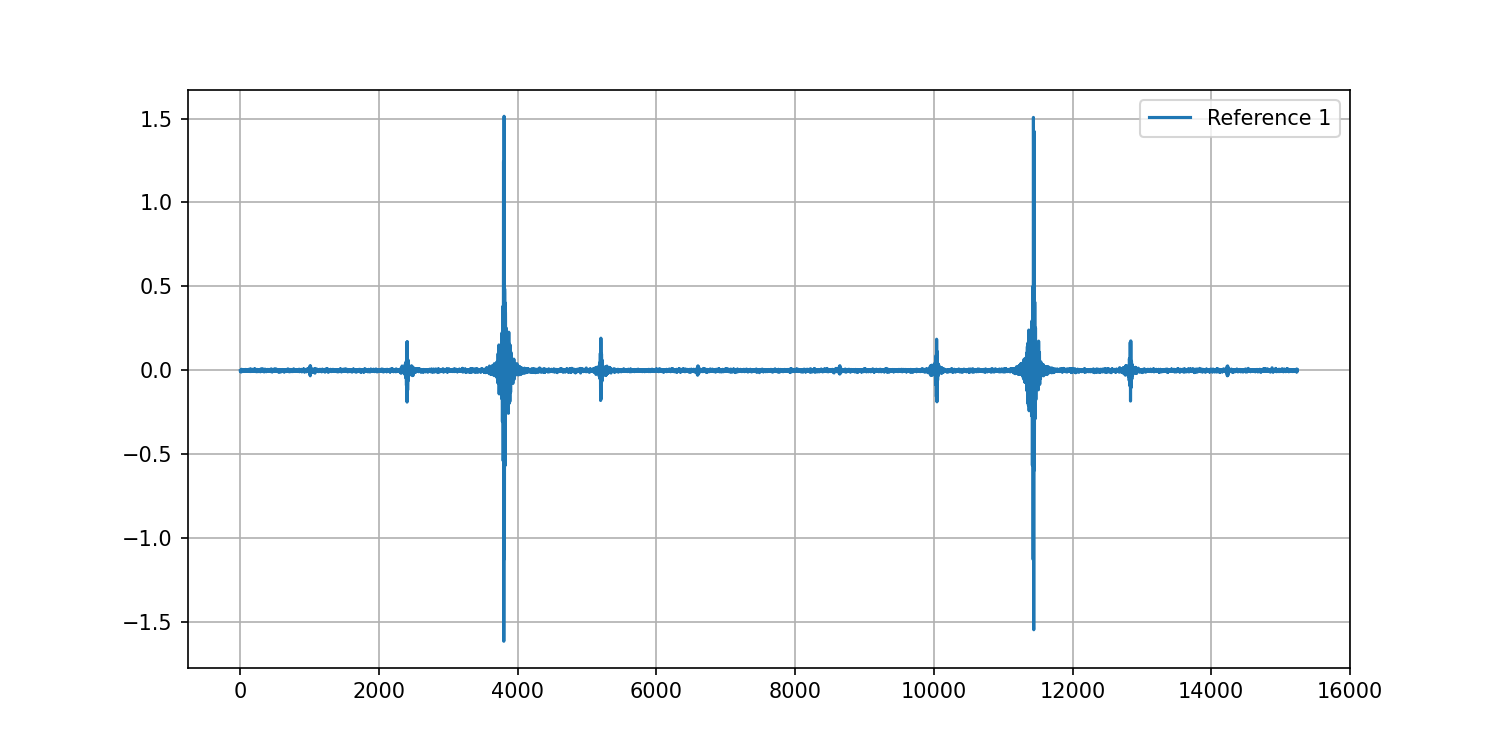

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>


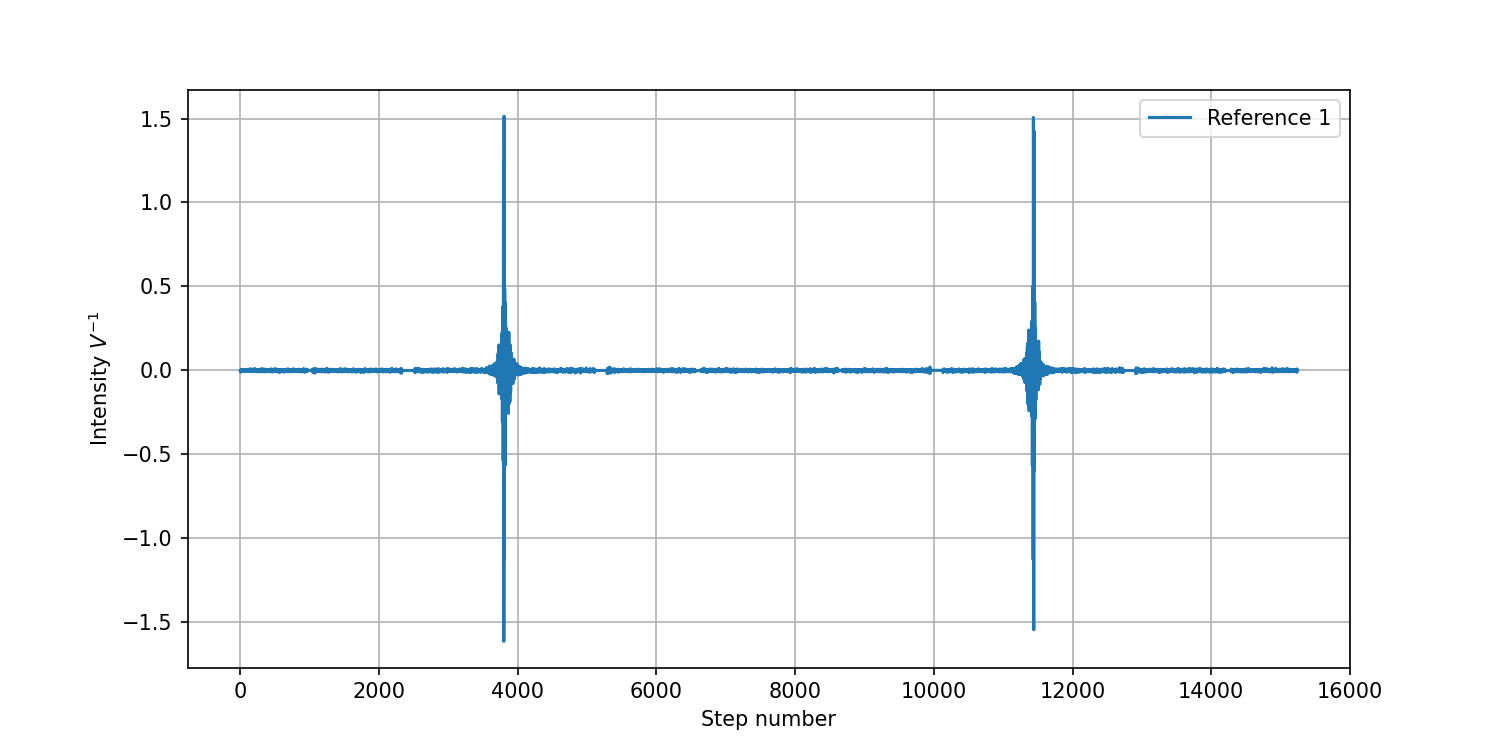

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


deleted old version of 2023-05-24_SUN_4K_averaged.txt
saved file 2023-05-24_SUN_4K_averaged.txt
Cell compiled at 2023-06-13 14:07:38


In [13]:
referenceData1Averaged = ftFuncs.average_IFGs_from_folder(refPath1)
referenceData1Averaged["IFG Value"] *= 10

saveFigTo = os.path.join(resultspath, "ReferenceIFG.png")
saveFigTo2 = os.path.join(resultspath, "ReferenceIFG.eps")

plt.figure(figsize=(10, 5))
plt.plot(referenceData1Averaged["IFG Value"], label = 'Reference 1')
plt.legend()
plt.grid()
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()

#referenceData1Averaged = ftFuncs.RemovedInternalReflections(referenceData1Averaged, True, 50, 75, 1, 1.5) 

smoothingRegions = np.array([[970, 1040], [2330, 2510], [5110, 5290], [6560, 6640], [8620, 8680], [9950, 10130], [12730, 12910], [14200, 14280]])
for i in range(smoothingRegions.shape[0]):
    smoothingRegion = smoothingRegions[i]
    referenceData1Averaged = ftFuncs.removed_internal_reflections(referenceData1Averaged, smoothingRegion)
    

saveFigTo = os.path.join(resultspath, "ReferenceAfterSmoothing.png")
saveFigTo2 = os.path.join(resultspath, "ReferenceAfterSmoothing.eps")

plt.figure(figsize=(10, 5))
plt.plot(referenceData1Averaged["IFG Value"], label = 'Reference 1')
plt.legend()
plt.grid()
plt.xlabel("Step number")
plt.ylabel("Intensity $V^{-1}$")
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()

# saves averaged data to txt file

if os.path.isfile(pathReferenceData1Averaged):
    os.remove(pathReferenceData1Averaged)
    print("deleted old version of " + nameReferenceData1Averaged)   

referenceData1Averaged.to_csv(pathReferenceData1Averaged, header=None, index=None, sep='\t', mode='a')
print("saved file " + nameReferenceData1Averaged)

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Below we convert IFGs to spectra

<IPython.core.display.Javascript object>


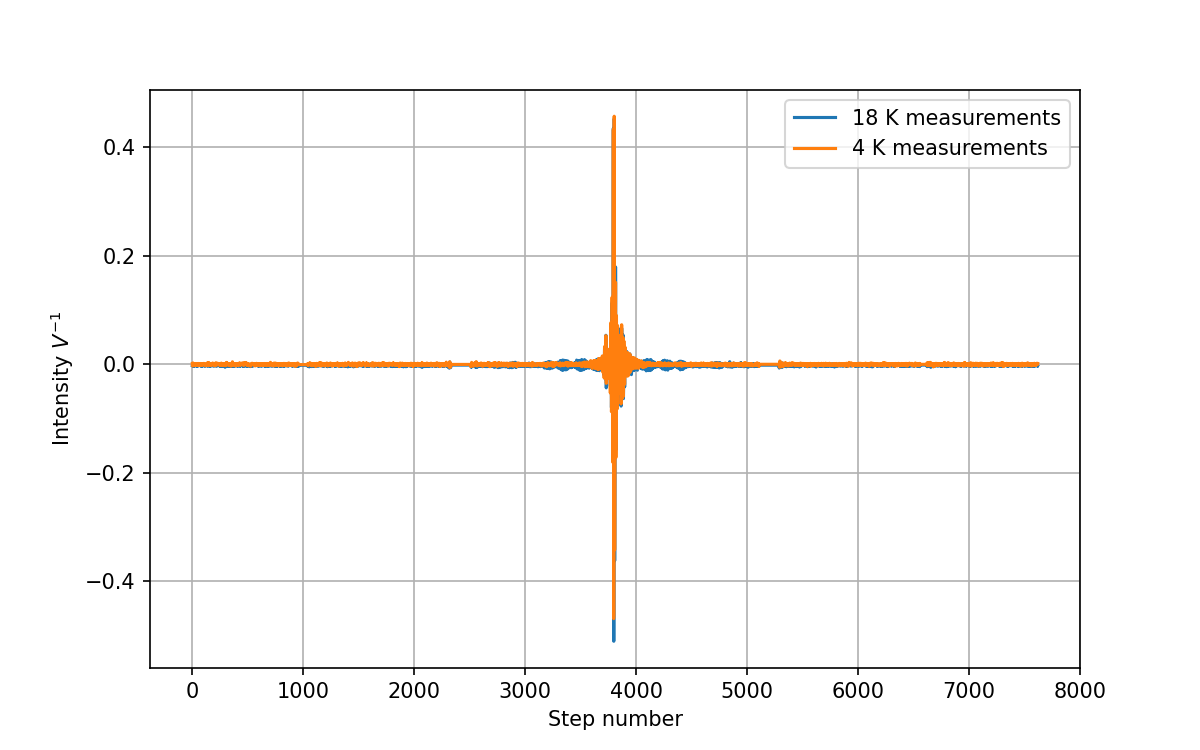

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


index_max apod:3803
index_max apod:3803
index_max apod:3803
index_max apod:3803
index_max apod:3803
index_max apod:3803


<IPython.core.display.Javascript object>


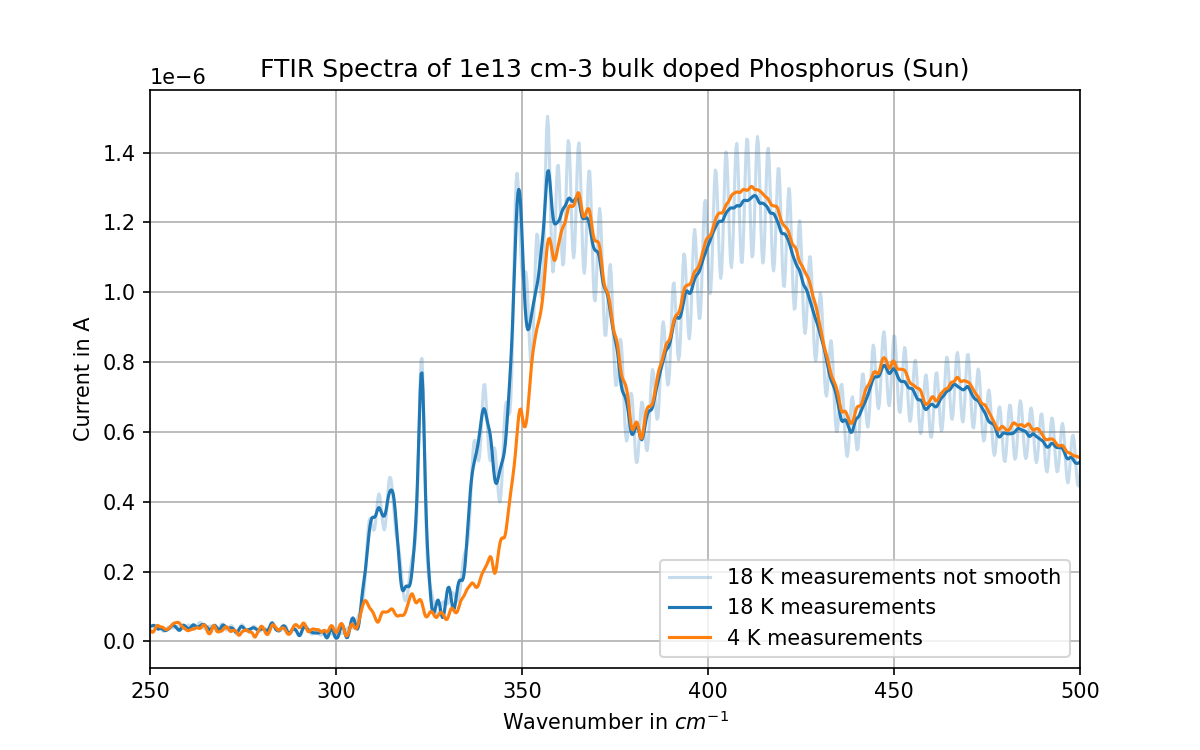

<IPython.core.display.Javascript object>


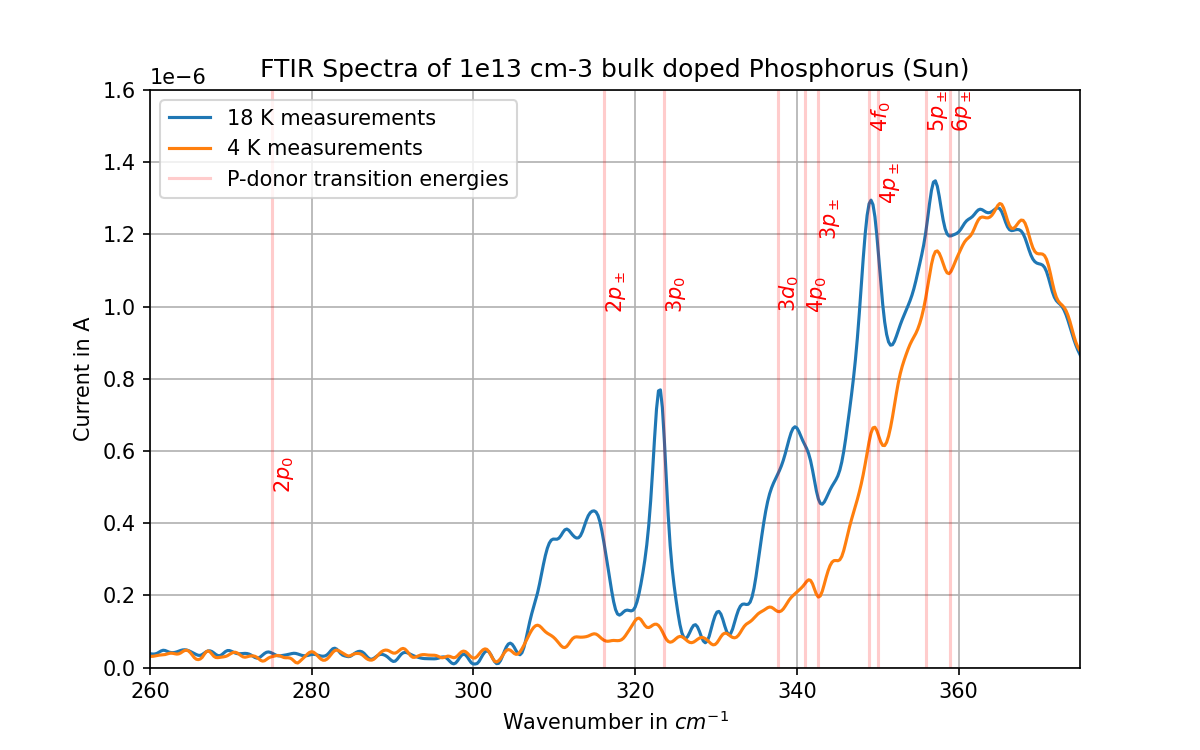

<IPython.core.display.Javascript object>


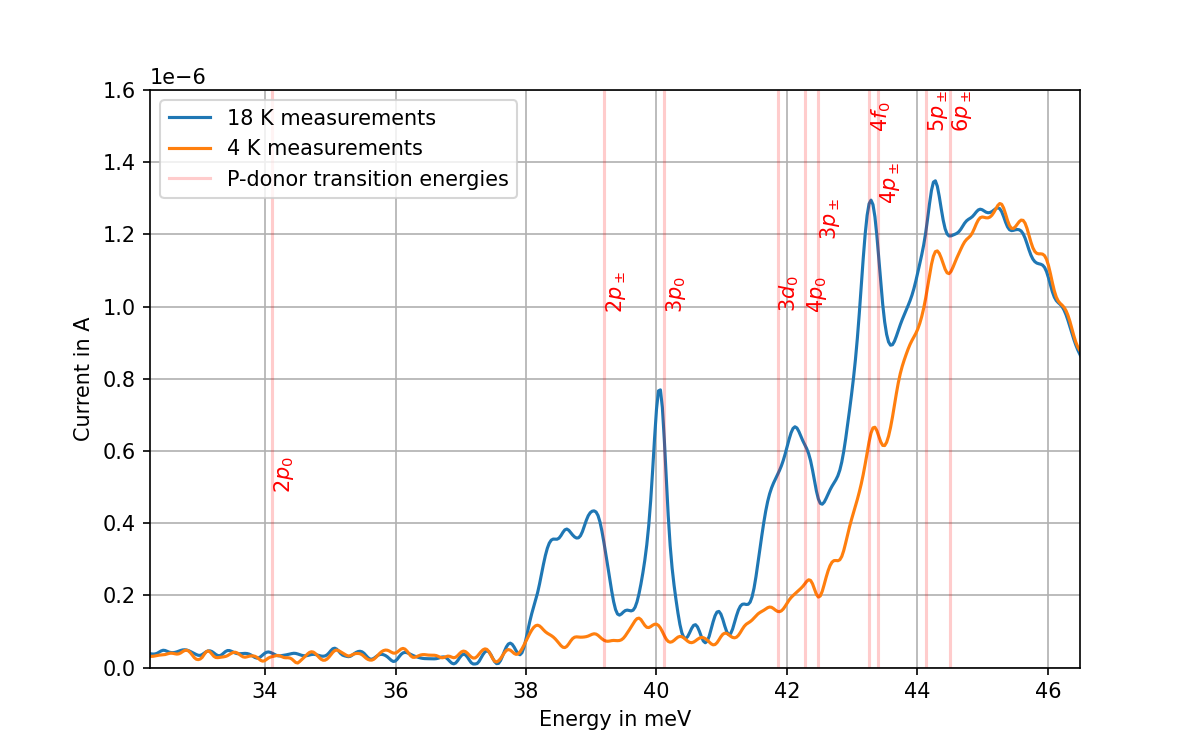

deleted old version of 2023-05-24_SUN_18K_averaged_FT.txt
saved file 2023-05-24_SUN_18K_averaged_FT.txt
deleted old version of 2023-05-24_SUN_18K_averagedAndSmoothed_FT.txt
saved file 2023-05-24_SUN_18K_averagedAndSmoothed_FT.txt
deleted old version of 2023-05-24_SUN_4K_FT.txt
saved file 2023-05-24_SUN_4K_FT.txt
Cell compiled at 2023-06-13 14:07:53


In [14]:
if not ('postProcessedAverage' in locals()): 
    postProcessedAverage = pd.read_csv(pathDataSmoothed, sep="\t", header=None, names=["Step", "IFG Value"])
if not ('preProcessedAverage' in locals()): 
    preProcessedAverage = pd.read_csv(pathDataAveraged, sep="\t", header=None, names=["Step", "IFG Value"])
if not ('referenceData1Averaged' in locals()):
    referenceData1Averaged = pd.read_csv(pathReferenceData1Averaged, sep="\t", header=None, names=["Step", "IFG Value"])

forSampleSmooth, backSampleSmooth = ftFuncs.split_IFG_forwards_backwards(postProcessedAverage)
forSampleRough, backSampleRough = ftFuncs.split_IFG_forwards_backwards(preProcessedAverage)
forRef1, backRef1 = ftFuncs.split_IFG_forwards_backwards(referenceData1Averaged)

saveFigTo = os.path.join(resultspath, "AllIFGs.png")
saveFigTo2 = os.path.join(resultspath, "AllIFGs.eps")


plt.figure(figsize=(8, 5))
plt.plot(backSampleSmooth["IFG Value"], label = '18 K measurements')
plt.plot(backRef1["IFG Value"]/3.3, label = '4 K measurements')
plt.xlabel("Step number")
plt.ylabel("Intensity $V^{-1}$")
plt.legend()
plt.grid()
plt.savefig(saveFigTo)
plt.savefig(saveFigTo2)
plt.show()

forSampleSmoothTrueSC, forSampleSmoothMagSC = ftFuncs.single_sided_IFG_to_spectrum_full(forSampleSmooth, 2, 4)
forSampleRoughTrueSC, forSampleRoughMagSC = ftFuncs.single_sided_IFG_to_spectrum_full(forSampleRough, 2, 4)
forRef1TrueSC, forRef1MagSC = ftFuncs.single_sided_IFG_to_spectrum_full(forRef1, 2, 4)

backSampleSmoothTrueSC, backSampleSmoothMagSC = ftFuncs.single_sided_IFG_to_spectrum_full(backSampleSmooth, 2, 4)
backSampleRoughTrueSC, backSampleRoughMagSC = ftFuncs.single_sided_IFG_to_spectrum_full(backSampleRough, 2, 4)
backRef1TrueSC, backRef1MagSC = ftFuncs.single_sided_IFG_to_spectrum_full(backRef1, 2, 4)

finalSampleSmooth = forSampleSmoothMagSC
finalSampleSmooth["Spectrum"] += backSampleSmoothMagSC["Spectrum"]
finalSampleSmooth["Spectrum"] /= 2

finalSampleRough = forSampleRoughMagSC
finalSampleRough["Spectrum"] += backSampleRoughMagSC["Spectrum"]
finalSampleRough["Spectrum"] /= 2

finalRef1 = forRef1MagSC
finalRef1["Spectrum"] += backRef1MagSC["Spectrum"]
finalRef1["Spectrum"] /= 2

################################################################################

sensitivity = 2e-7

saveFigTo = os.path.join(resultspath, "Spectrum.png")

plt.figure(figsize=(8, 5))
plt.plot(finalSampleRough["Wavenumbers"], finalSampleRough["Spectrum"]*sensitivity, c='tab:blue' , label = '18 K measurements not smooth', alpha = 0.25)
plt.plot(finalSampleSmooth["Wavenumbers"], finalSampleSmooth["Spectrum"]*sensitivity, c='tab:blue' , label = '18 K measurements')
plt.plot(finalRef1["Wavenumbers"], finalRef1["Spectrum"]/3.3*sensitivity, c='tab:orange' , label = '4 K measurements')
plt.legend()
plt.title("FTIR Spectra of " + sampleName)
plt.xlim(250,500)
plt.xlabel("Wavenumber in $cm^{-1}$")
plt.ylabel("Current in A")
plt.grid()
plt.savefig(saveFigTo)
plt.show()

################################################################################

saveFigTo = os.path.join(resultspath, "Spectrum.png")

plt.figure(figsize=(8, 5))
plt.plot(finalSampleSmooth["Wavenumbers"], finalSampleSmooth["Spectrum"]*sensitivity, label = '18 K measurements')
plt.plot(finalRef1["Wavenumbers"], finalRef1["Spectrum"]/3.3*sensitivity, label = '4 K measurements')

plt.axvline(x=ftFuncs.wavenumber(34.11/1000), color='r', alpha=0.2, label='P-donor transition energies')
plt.text(ftFuncs.wavenumber(34.11/1000), 0.5e-6, '$2p_0$',color='r',rotation=90) 

plt.axvline(x=ftFuncs.wavenumber(39.19/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(39.19/1000), 1e-6, '$2p_\pm$',color='r',rotation=90)

plt.axvline(x=ftFuncs.wavenumber(40.12/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(40.12/1000), 1e-6, '$3p_0$',color='r',rotation=90)

plt.axvline(x=ftFuncs.wavenumber(41.86/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(41.86/1000), 1e-6, '$3d_0$',color='r',rotation=90)

plt.axvline(x=ftFuncs.wavenumber(42.28/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(42.28/1000), 1e-6, '$4p_0$',color='r',rotation=90)

plt.axvline(x=ftFuncs.wavenumber(42.47/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(42.47/1000), 1.2e-6, '$3p_\pm$',color='r',rotation=90) #oder 42.46

plt.axvline(x=ftFuncs.wavenumber(43.26/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(43.26/1000), 1.5e-6, '$4f_0$',color='r',rotation=90)

plt.axvline(x=ftFuncs.wavenumber(43.39/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(43.39/1000), 1.3e-6, '$4p_\pm$',color='r',rotation=90) #oder 43.40

plt.axvline(x=ftFuncs.wavenumber(44.13/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(44.13/1000), 1.5e-6, '$5p_\pm$',color='r',rotation=90)

plt.axvline(x=ftFuncs.wavenumber(44.50/1000), c='r', alpha=0.2)
plt.text(ftFuncs.wavenumber(44.50/1000), 1.5e-6, '$6p_\pm$',color='r',rotation=90)

plt.legend()
plt.title("FTIR Spectra of " + sampleName)
plt.xlim(260,375)
plt.ylim(0,1.6e-6)
plt.xlabel("Wavenumber in $cm^{-1}$")
plt.ylabel("Current in A")
plt.grid()
plt.savefig(saveFigTo)
plt.show()

################################################################################

saveFigTo = os.path.join(resultspath, "SpectrumEnergy.png")

plt.figure(figsize=(8, 5))
plt.plot(ftFuncs.energy(finalSampleSmooth["Wavenumbers"])*1000, finalSampleSmooth["Spectrum"]*sensitivity, label = '18 K measurements')
plt.plot(ftFuncs.energy(finalRef1["Wavenumbers"])*1000, finalRef1["Spectrum"]/3.3*sensitivity, label = '4 K measurements')

plt.axvline(x=34.11, color='r', alpha=0.2, label='P-donor transition energies')
plt.text(34.11, 0.5e-6, '$2p_0$',color='r',rotation=90) 

plt.axvline(x=39.19, c='r', alpha=0.2)
plt.text(39.19, 1e-6, '$2p_\pm$',color='r',rotation=90)

plt.axvline(x=40.12, c='r', alpha=0.2)
plt.text(40.12, 1e-6, '$3p_0$',color='r',rotation=90)

plt.axvline(x=41.86, c='r', alpha=0.2)
plt.text(41.86, 1e-6, '$3d_0$',color='r',rotation=90)

plt.axvline(x=42.28, c='r', alpha=0.2)
plt.text(42.28, 1e-6, '$4p_0$',color='r',rotation=90)

plt.axvline(x=42.47, c='r', alpha=0.2)
plt.text(42.47, 1.2e-6, '$3p_\pm$',color='r',rotation=90) #oder 42.46

plt.axvline(x=43.26, c='r', alpha=0.2)
plt.text(43.26, 1.5e-6, '$4f_0$',color='r',rotation=90)

plt.axvline(x=43.39, c='r', alpha=0.2)
plt.text(43.39, 1.3e-6, '$4p_\pm$',color='r',rotation=90) #oder 43.40

plt.axvline(x=44.13, c='r', alpha=0.2)
plt.text(44.13, 1.5e-6, '$5p_\pm$',color='r',rotation=90)

plt.axvline(x=44.50, c='r', alpha=0.2)
plt.text(44.50, 1.5e-6, '$6p_\pm$',color='r',rotation=90)

plt.legend()
#plt.title("FTIR Spectra of " + sampleName)
plt.xlim(ftFuncs.energy(260)*1000,ftFuncs.energy(375)*1000)
plt.ylim(0,1.6e-6)
plt.xlabel("Energy in meV")
plt.ylabel("Current in A")
plt.grid()
plt.savefig(saveFigTo)
plt.show()


# saves all the fourier transformed data
paths = [pathDataRoughFt, pathDataSmoothFt, pathRef1Ft]
names = [nameDataRoughFt, nameDataSmoothFt, nameRef1Ft]
files = [finalSampleRough, finalSampleSmooth, finalRef1]

for i in range (len(paths)):
    
    if os.path.isfile(paths[i]):
        os.remove(paths[i])
        print("deleted old version of " + names[i])   

    files[i].to_csv(paths[i], header=0, index=None, sep='\t', mode='a')
    print("saved file " + names[i])

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

# Integrates Spectrum and compares to peak value of interferogram

In [18]:
filenames = ['postProcessedAverage', 'preProcessedAverage', 'referenceData1Averaged']
names = ["Sample post-processing", "Sample pre-processing", "Reference scan 1"]
paths = [pathDataSmoothed, pathDataAveraged, pathReferenceData1Averaged]

for i in range (len(filenames)):
    
    # gets interferogram
    if (filenames[i] in locals()): 
        IFG = locals()[filenames[i]].copy()
    else: 
        IFG = pd.read_csv(paths[i], sep="\t", header=None, names=["Step", "IFG Value"])
    
    # gets height of interferogram peak
    IFGfolded = ftFuncs.splitAndFold(IFG)
    peak = IFGfolded.max(axis='rows')["IFG Value"]
    # gets FFT of interferogram and calculates area using numerical quadrature
    area = ftFuncs.getArea(IFGfolded)
    
    print(names[i], ": IFG Peak value = ", peak, ", Spectrum integral = ", area)

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

Sample post-processing : IFG Peak value =  0.46135082916666675 , Spectrum integral =  0.46232512162865574
Sample pre-processing : IFG Peak value =  0.46135082916666675 , Spectrum integral =  0.4623265288258318
Reference scan 1 : IFG Peak value =  1.5108044 , Spectrum integral =  1.5117624749895642
Cell compiled at 2023-06-09 18:12:49


C:\Users\theow\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\theow\Anaconda3\lib\site-packages\pandas\core\indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


<IPython.core.display.Javascript object>


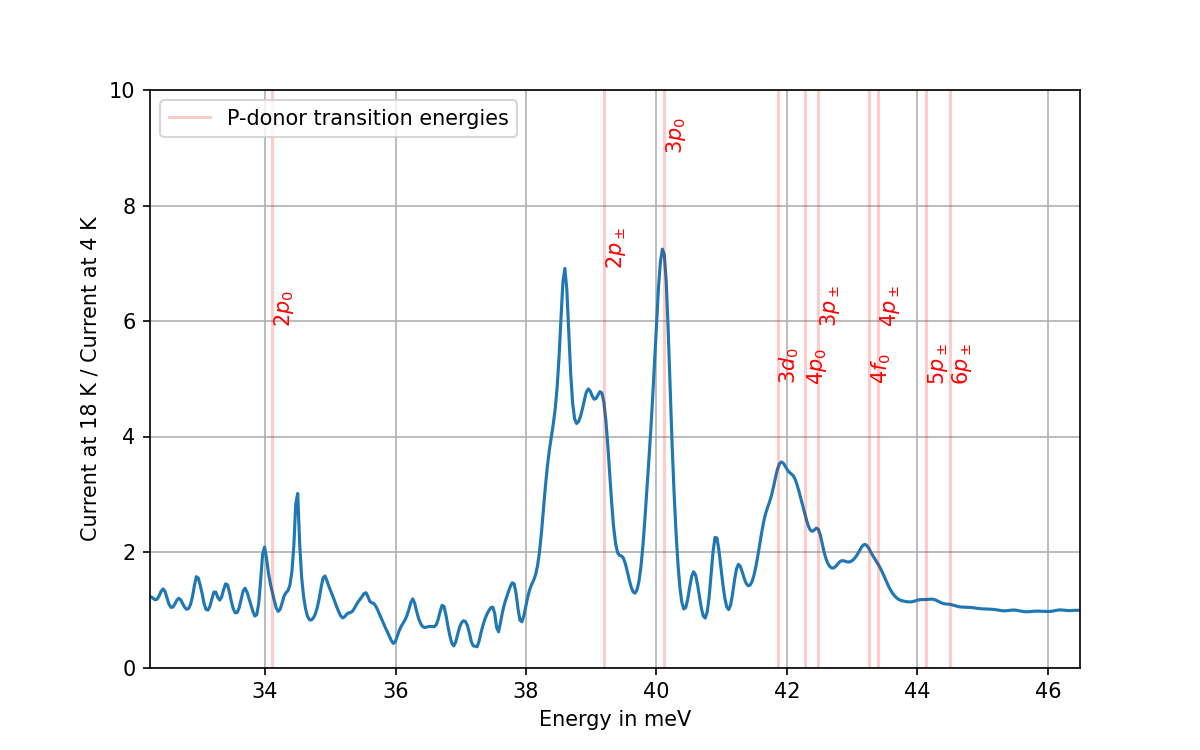

Cell compiled at 2023-06-13 14:57:04


In [3]:
if not ('finalSampleSmooth' in locals()):
    finalSampleSmooth = pd.read_csv(pathDataSmoothFt, sep="\t", header=None, names=["Wavenumbers", "Spectrum"])
if not ('finalRef1' in locals()):
    finalRef1 = pd.read_csv(pathRef1Ft, sep="\t", header=None, names=["Wavenumbers", "Spectrum"])


saveFigTo = os.path.join(resultspath, "AbsorptionRatio.png")

plt.figure(figsize=(8, 5))
plt.plot(ftFuncs.energy(finalSampleSmooth["Wavenumbers"])*1000, finalSampleSmooth["Spectrum"]*3.3/finalRef1["Spectrum"])

plt.axvline(x=34.11, color='r', alpha=0.2, label='P-donor transition energies')
plt.text(34.11, 6, '$2p_0$',color='r',rotation=90) 

plt.axvline(x=39.19, c='r', alpha=0.2)
plt.text(39.19, 7, '$2p_\pm$',color='r',rotation=90)

plt.axvline(x=40.12, c='r', alpha=0.2)
plt.text(40.12, 9, '$3p_0$',color='r',rotation=90)

plt.axvline(x=41.86, c='r', alpha=0.2)
plt.text(41.86, 5, '$3d_0$',color='r',rotation=90)

plt.axvline(x=42.28, c='r', alpha=0.2)
plt.text(42.28, 5, '$4p_0$',color='r',rotation=90)

plt.axvline(x=42.47, c='r', alpha=0.2)
plt.text(42.47, 6, '$3p_\pm$',color='r',rotation=90) #oder 42.46

plt.axvline(x=43.26, c='r', alpha=0.2)
plt.text(43.26, 5, '$4f_0$',color='r',rotation=90)

plt.axvline(x=43.39, c='r', alpha=0.2)
plt.text(43.39, 6, '$4p_\pm$',color='r',rotation=90) #oder 43.40

plt.axvline(x=44.13, c='r', alpha=0.2)
plt.text(44.13, 5, '$5p_\pm$',color='r',rotation=90)

plt.axvline(x=44.50, c='r', alpha=0.2)
plt.text(44.50, 5, '$6p_\pm$',color='r',rotation=90)

plt.legend()
#plt.title("Absorbance of " + sampleName)
plt.xlim(ftFuncs.energy(260)*1000,ftFuncs.energy(375)*1000)
plt.ylim(0,10)
plt.xlabel("Energy in meV")
plt.ylabel("Current at 18 K / Current at 4 K")
plt.grid()
plt.savefig(saveFigTo)
plt.show()

print("Cell compiled at " + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

In [4]:
ftFuncs.energy(1.035)

0.00012832364537836225